In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.4'
os.environ['OMP_NUM_THREADS']='1'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)
#os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=1'

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
   "NCCL_PROTO": "SIMPLE,LL,LL128",
 })

import sys
sys.path.append('../')

from models import gauge
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'classic'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CpuDevice(id=0)]

In [ ]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        #x = nn.Dense(4, use_bias=False,
        #                 kernel_init=self.kernel_init,
        #                 bias_init=self.bias_init)(x)
        #x = jnp.sin(x)
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            #x= nn.tanh(x)
            #x = jnp.tan(x)
            x = arcsinh(x)
            #x = nn.relu(x)
        x = nn.Dense(self.volume, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        #x= jnp.sin(x)
        x = jnp.ravel(jnp.sin(jnp.tensordot(jnp.arange(1,self.n+1), x, axes=0)))
        x1 = MLP(self.volume, self.features)(x)
        #x2 = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=True,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = nn.celu(x)
        x = nn.Dense(self.volume, use_bias=True,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


class CV_MLP_Periodic(nn.Module):
    volume: int
    features: Sequence[int]
    n: int

    @nn.compact
    def __call__(self, x):
        pl = jnp.exp(1j*x)

        powers = jnp.array([pl**i for i in range(1, self.n+1)])
        sinx = jnp.hstack((powers.imag, powers.real))[0]
        
        x1 = MLP(self.volume, self.features)(sinx)

        y = self.param('bias', nn.initializers.ones, (1,))
        return x1, y

# A=1

jack bin size 1: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0004330303667045552+0.00128229914958399j))
bin size 1: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0004322590017012882+0.001282298865422067j))
jack bin size 2: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0005500436099020957+0.0016287565340216993j))
bin size 2: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0005499981363652033+0.0016287563226193378j))
jack bin size 4: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0006771064944703329+0.0020012471279843556j))
bin size 4: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0006771870683273469+0.002001247079038336j))
jack bin size 5: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0007182450907003965+0.0021171321632105847j))
bin size 5: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0007182183247695014+0.002117131908712784j))
jack bin size 10: (np.complex64(0.9038549-0.0007751576j), np.complex128(0.0008140

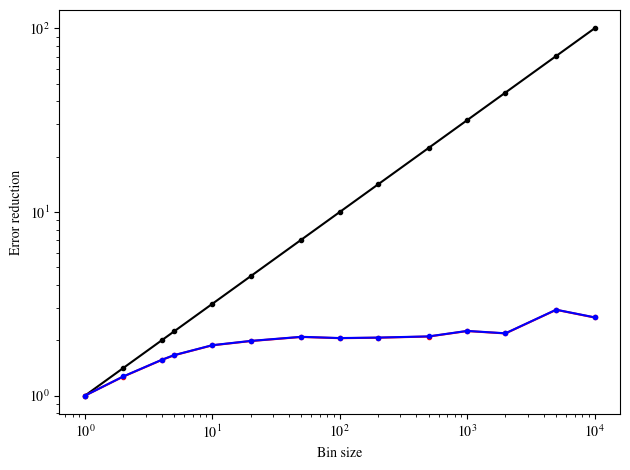

In [13]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [32]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)



def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [29]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V).real)(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_l1_w16_sin4x_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027496501803398132 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 1.7512153362986282e-06 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.90482044), np.complex128(3.772759788015785e-05+0j)) <f>: (np.float32(-0.0019202377), np.complex128(0.0029877270206361516+0j))
Epoch 200: <Test loss>: 2.527839626509376e-07 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.9047479), np.complex128(1.6165148701225194e-05+0j)) <f>: (np.float32(-0.0018479369), np.complex128(0.0029956421106747495+0j))
Epoch 300: <Test loss>: 8.706329595042916e-07 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.9047519), np.complex128(2.3080413240561974e-05+0j)) <f>: (np.float32(-0.0018519098), np.complex128(0.003

In [31]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V).real)(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_l1_w16_sin4x_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027496501803398132 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 1.5279030094461632e-06 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.90477103), np.complex128(3.1476408239041714e-05+0j)) <f>: (np.float32(-0.0018715567), np.complex128(0.002985148958388357+0j))
Epoch 400: <Test loss>: 1.0938186960629537e-06 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.9047538), np.complex128(2.6864595244877127e-05+0j)) <f>: (np.float32(-0.0018541492), np.complex128(0.0030023758742862504+0j))
Epoch 600: <Test loss>: 4.09015825653114e-07 <O>: (np.float32(0.90290004), np.complex128(0.0029891262936699655+0j)) <O-f>: (np.float32(0.90474844), np.complex128(1.5103468721257717e-05+0j)) <f>: (np.float32(-0.0018480339), np.complex128(0.00

In [33]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_l1_w16_sin4x_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027496501803398132 <O>: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0029891262936699655+0.013873107843890271j)) <O-f>: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0029891262936699655+0.013873107843890271j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.2530606454674853e-06 <O>: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0029891262936699655+0.013873107843890271j)) <O-f>: (np.complex64(0.9047327+0.0080681415j), np.complex128(3.5646690649378044e-05+0.013873107843890271j)) <f>: (np.float32(-0.0018323724), np.complex128(0.0029759878429881886+0j))
Epoch 800: <Test loss>: 1.5756725701976393e-07 <O>: (np.complex64(0.90290004+0.0080681415j), np.complex128(0.0029891262936699655+0.013873107843890271j)) <O-f>: (np.complex64(0.9047427+0.0080681415j), np.complex128(1.1937583749286872e-05+0.013873107843890271j)) <f>: (np.float32(-0.0018420477), np.complex128(0.002989427460866908+0j))
Epoch 1200: <Test loss>: 1.56480

## Smaller learning rate

In [62]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

In [59]:
binsize=1

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-4)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:binsize]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %( 100*binsize) ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(10000//100//binsize):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.03300852328538895 (np.complex64(0.8954762+0.0064057074j), np.complex128(0.010443613707733062+0.026720053036273058j))
Epoch 100: 5.104639058117755e-06 (np.complex64(0.90470886+0.0064057074j), np.complex128(9.708646783613547e-05+0.026720053036273058j))
Epoch 200: 1.0482721336302347e-05 (np.complex64(0.90454173+0.0064057074j), np.complex128(0.00014689791583735767+0.026720053036273058j))
Epoch 300: 4.240894213580759e-06 (np.complex64(0.9046633+0.0064057074j), np.complex128(0.0001161766813317085+0.026720053036273058j))
Epoch 400: 5.454377856040082e-07 (np.complex64(0.9047024+0.0064057074j), np.complex128(3.8880899995502535e-05+0.026720053036273058j))
Epoch 500: 5.060584271632251e-07 (np.complex64(0.9047648+0.0064057074j), np.complex128(2.009102315601579e-05+0.026720053036273058j))
Epoch 600: 4.4200461957188963e-07 (np.complex64(0.904773+0.0064057074j), np.complex128(1.8525790615804127e-05+0.026720053036273058j))
Epoch 700: 5.070582460575679e-07 (np.complex64(0.904765+0.0064057074

In [61]:
binsize=2

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-4)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:binsize]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %( 100*binsize) ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(10000//100//binsize):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.03300852328538895 (np.complex64(0.8954762+0.0064057074j), np.complex128(0.010443613707733062+0.026720053036273058j))
Epoch 200: 3.897347141901264e-06 (np.complex64(0.9047361+0.0064057074j), np.complex128(7.05977012485527e-05+0.026720053036273058j))
Epoch 400: 8.793987035460304e-06 (np.complex64(0.9046169+0.0064057074j), np.complex128(0.00013341356371987574+0.026720053036273058j))
Epoch 600: 3.1929494070936926e-06 (np.complex64(0.9047394+0.0064057074j), np.complex128(8.072638287074308e-05+0.026720053036273058j))
Epoch 800: 4.268296720510989e-07 (np.complex64(0.90471256+0.0064057074j), np.complex128(3.5302803126584586e-05+0.026720053036273058j))
Epoch 1000: 3.0673436413053423e-07 (np.complex64(0.90472955+0.0064057074j), np.complex128(1.6611735871506963e-05+0.026720053036273058j))
Epoch 1200: 6.197185484779766e-07 (np.complex64(0.9047477+0.0064057074j), np.complex128(2.914040008696806e-05+0.026720053036273058j))
Epoch 1400: 8.958369335232419e-07 (np.complex64(0.90476334+0.00640

In [63]:
binsize=4

opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-4)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:binsize]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %( 100*binsize) ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(10000//100//binsize):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.03300852328538895 (np.complex64(0.8954762+0.0064057074j), np.complex128(0.010443613707733062+0.026720053036273058j))
Epoch 400: 1.5407589671667665e-05 (np.complex64(0.9048091+0.0064057074j), np.complex128(6.916801337250306e-05+0.026720053036273058j))
Epoch 800: 5.235655748947465e-07 (np.complex64(0.9046852+0.0064057074j), np.complex128(3.7051811166546945e-05+0.026720053036273058j))
Epoch 1200: 2.689377822662209e-07 (np.complex64(0.90470594+0.0064057074j), np.complex128(2.6411189314344452e-05+0.026720053036273058j))
Epoch 1600: 5.415330406322028e-07 (np.complex64(0.9046937+0.0064057074j), np.complex128(4.0503677718517714e-05+0.026720053036273058j))
Epoch 2000: 2.3347867283973756e-07 (np.complex64(0.9047016+0.0064057074j), np.complex128(2.8417391476421872e-05+0.026720053036273058j))
Epoch 2400: 6.112729238338943e-07 (np.complex64(0.90473115+0.0064057074j), np.complex128(3.387605683199201e-05+0.026720053036273058j))
Epoch 2800: 3.9119314010349626e-07 (np.complex64(0.9047418+0.0

## acceptance rate 0.99

jack bin size 1: (np.complex64(0.9200903-0.07042321j), np.complex128(0.00033889309912914174+0.0011706668785148421j))
bin size 1: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0003386943850788071+0.0011707708832353768j))
jack bin size 2: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0004793066634110626+0.0016551731151737727j))
bin size 2: (np.complex64(0.9200903-0.07042321j), np.complex128(0.00047870856369191373+0.0016552318671437672j))
jack bin size 4: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0006762800709119973+0.002339814180102348j))
bin size 4: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0006764212797410624+0.0023398231778579124j))
jack bin size 5: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0007558317363898969+0.002615382455788268j))
bin size 5: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0007559366405222635+0.00261545983326821j))
jack bin size 10: (np.complex64(0.9200903-0.07042321j), np.complex128(0.0010669102644792503+0.

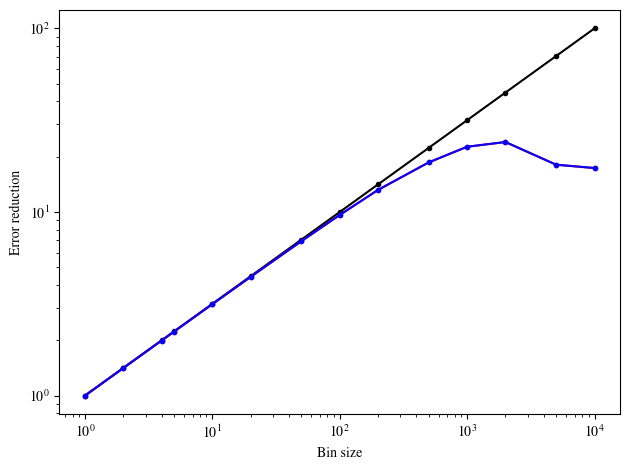

In [34]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.99.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [39]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [38]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.023744657635688782 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0002096991374855861 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.90577126+0.025512164j), np.complex128(0.00144273397217398+0.05811393680122345j)) <f>: (np.float32(-0.0013806064), np.complex128(0.012596513123805482+0j))
Epoch 200: <Test loss>: 0.0001849098043749109 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.90573627+0.025512164j), np.complex128(0.0013439333710850493+0.05811393680122345j)) <f>: (np.float32(-0.0013462153), np.complex128(0.012663266186018424+0j))
Epoch 300: <Test loss>: 0.00018687314877752215 <O>: (np.c

In [40]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.023744657635688782 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.00021636695601046085 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9057767+0.025512164j), np.complex128(0.0014715170057934726+0.05811393680122345j)) <f>: (np.float32(-0.0013858991), np.complex128(0.01261792314296874+0j))
Epoch 400: <Test loss>: 0.00020024183322675526 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9057289+0.025512164j), np.complex128(0.0014173142682618748+0.05811393680122345j)) <f>: (np.float32(-0.0013383317), np.complex128(0.01261387375083462+0j))
Epoch 600: <Test loss>: 0.00019402033649384975 <O>: (np.c

In [42]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.023744657635688782 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00019322361913509667 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.905702+0.025512164j), np.complex128(0.0013977358632475008+0.05811393680122345j)) <f>: (np.float32(-0.0013113043), np.complex128(0.012620983021987381+0j))
Epoch 800: <Test loss>: 0.00016806369239930063 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.90568817+0.025512164j), np.complex128(0.0012833706014340278+0.05811393680122345j)) <f>: (np.float32(-0.0012968376), np.complex128(0.012690694474694298+0j))
Epoch 1200: <Test loss>: 0.0001589172607054934 <O>: (np

In [44]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.023744657635688782 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0002572727098595351 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.90584415+0.025512164j), np.complex128(0.0016078103856886185+0.05811393680122345j)) <f>: (np.float32(-0.0014534853), np.complex128(0.012507828391412502+0j))
Epoch 1600: <Test loss>: 0.0002354927419219166 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9058076+0.025512164j), np.complex128(0.001541706088869594+0.05811393680122345j)) <f>: (np.float32(-0.0014166029), np.complex128(0.012546015478588078+0j))
Epoch 2400: <Test loss>: 0.00019881500338669866 <O>: (np

In [46]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.99_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.023744657635688782 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0002735530724748969 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9058687+0.025512164j), np.complex128(0.001655726416559863+0.05811393680122345j)) <f>: (np.float32(-0.0014781955), np.complex128(0.012490906194809914+0j))
Epoch 3200: <Test loss>: 0.00027035994571633637 <O>: (np.complex64(0.9043903+0.025512164j), np.complex128(0.013477231555730775+0.05811393680122345j)) <O-f>: (np.complex64(0.9058424+0.025512164j), np.complex128(0.00165664057444578+0.05811393680122345j)) <f>: (np.float32(-0.0014512303), np.complex128(0.012497135560453832+0j))
Epoch 4800: <Test loss>: 0.0002567582705523819 <O>: (np.c

## acceptance rate 0.9

jack bin size 1: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0004268902294121421+0.0012776909818128194j))
bin size 1: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0004263263614455402+0.0012776927993401062j))
jack bin size 2: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0005953459844348571+0.001791437758246601j))
bin size 2: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0005949926941301524+0.0017914386302536327j))
jack bin size 4: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0008247748095434464+0.002501039249612612j))
bin size 4: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0008248785695969781+0.002501039228421269j))
jack bin size 5: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0009139807189024171+0.00278011581841112j))
bin size 5: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0009139883235001872+0.0027801131421711063j))
jack bin size 10: (np.complex64(0.9047381-0.011290232j), np.complex128(0.0012402988511304

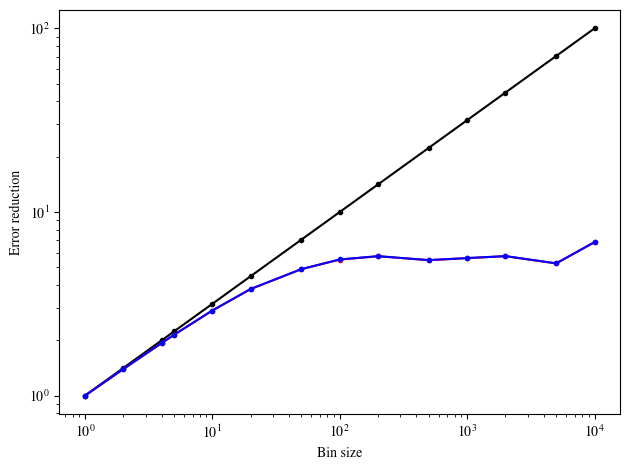

In [47]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [50]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [49]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027309022843837738 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 6.785446657886496e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050665-0.010577672j), np.complex128(2.6922824285903484e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016839041), np.complex128(0.004388435863353048+0j))
Epoch 200: <Test loss>: 1.391176169818209e-06 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.90508515-0.010577672j), np.complex128(3.6828282690973e-05+0.011090647707421216j)) <f>: (np.float32(-0.0017022017), np.complex128(0.004393612285553569+0j))
Epoch 300: <Test loss>: 2.2467499150025105e-07 <O>:

In [51]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027309022843837738 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 4.4648712105299637e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.90508586-0.010577672j), np.complex128(1.7845700550883714e-05+0.011090647707421216j)) <f>: (np.float32(-0.0017030096), np.complex128(0.00436659401051734+0j))
Epoch 400: <Test loss>: 1.094619847208378e-06 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050907-0.010577672j), np.complex128(3.287364159137389e-05+0.011090647707421216j)) <f>: (np.float32(-0.0017075872), np.complex128(0.00439510873384975+0j))
Epoch 600: <Test loss>: 2.967001933029678e-07 <O>:

In [52]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [53]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027309022843837738 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 5.420960746960191e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050531-0.010577672j), np.complex128(1.8796897783907883e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016702638), np.complex128(0.00437694482514789+0j))
Epoch 800: <Test loss>: 4.800807573701604e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050628-0.010577672j), np.complex128(2.0126605587778593e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016790652), np.complex128(0.0043824678306601415+0j))
Epoch 1200: <Test loss>: 1.0878067087105592e-06 <

In [54]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [55]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027309022843837738 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 3.2610591915727127e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050369-0.010577672j), np.complex128(1.1945781128071066e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016540121), np.complex128(0.004370599762585855+0j))
Epoch 1600: <Test loss>: 4.5169832674218924e-07 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9050328-0.010577672j), np.complex128(1.3711996626678237e-05+0.011090647707421216j)) <f>: (np.float32(-0.001649773), np.complex128(0.004364742352384833+0j))
Epoch 2400: <Test loss>: 1.618479785747695e-07 

In [56]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [57]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.027309022843837738 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 1.2184833622086444e-06 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.90506893-0.010577672j), np.complex128(4.0441258311453446e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016855043), np.complex128(0.0043631494899902205+0j))
Epoch 3200: <Test loss>: 1.1670326784951612e-06 <O>: (np.complex64(0.9033833-0.010577672j), np.complex128(0.004368593841895857+0.011090647707421216j)) <O-f>: (np.complex64(0.90507126-0.010577672j), np.complex128(4.0037524274271785e-05+0.011090647707421216j)) <f>: (np.float32(-0.0016873456), np.complex128(0.004365204125172057+0j))
Epoch 4800: <Test loss>: 1.100501435757905

## acceptance rate 0.95

jack bin size 1: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.00042859684770099555+0.001305564321150812j))
bin size 1: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0004282258901298091+0.001305564805055689j))
jack bin size 2: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0006023887418541169+0.0018411419133634148j))
bin size 2: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0006025976624795194+0.0018411516484107403j))
jack bin size 4: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0008458215038183703+0.002592991273301853j))
bin size 4: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0008459799539647716+0.0025929930447002327j))
jack bin size 5: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0009427475261472895+0.0028936607157635146j))
bin size 5: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0009426284552783121+0.0028936610659327316j))
jack bin size 10: (np.complex64(0.9007107-0.0040705325j), np.complex128(0.0013

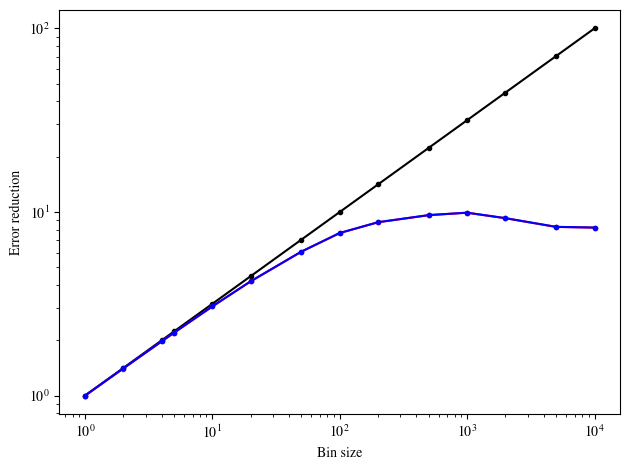

In [3]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=1
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [6]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 4.267893700671266e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9049784-0.017321236j), np.complex128(1.8844690553794405e-05+0.016452376790242935j)) <f>: (np.float32(0.007620214), np.complex128(0.003959610818218541+0j))
Epoch 200: <Test loss>: 1.657853516690011e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90496516-0.017321236j), np.complex128(1.592344545450573e-05+0.016452376790242935j)) <f>: (np.float32(0.007633211), np.complex128(0.0039537726908372055+0j))
Epoch 300: <Test loss>: 2.1450438225656399e-07 <

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 4.4563924461726856e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90497595-0.017321236j), np.complex128(1.778450614202731e-05+0.016452376790242935j)) <f>: (np.float32(0.007622666), np.complex128(0.003970135178226268+0j))
Epoch 400: <Test loss>: 2.280391129261261e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9049782-0.017321236j), np.complex128(1.5371481678677846e-05+0.016452376790242935j)) <f>: (np.float32(0.0076205702), np.complex128(0.003970490388062594+0j))
Epoch 600: <Test loss>: 2.1265235261580528e-07 

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 7.230872824948165e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050308-0.017321236j), np.complex128(2.5403846330126397e-05+0.016452376790242935j)) <f>: (np.float32(0.007568607), np.complex128(0.003948658176636729+0j))
Epoch 800: <Test loss>: 2.419126587938081e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90496635-0.017321236j), np.complex128(1.6282271810622144e-05+0.016452376790242935j)) <f>: (np.float32(0.0076321443), np.complex128(0.003960570645940557+0j))
Epoch 1200: <Test loss>: 1.6143155789904995e-07

In [10]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 9.256223165721167e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050547-0.017321236j), np.complex128(3.39947072247533e-05+0.016452376790242935j)) <f>: (np.float32(0.0075435783), np.complex128(0.003989065579010658+0j))
Epoch 1600: <Test loss>: 3.449098642249737e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.905041-0.017321236j), np.complex128(2.203961472276403e-05+0.016452376790242935j)) <f>: (np.float32(0.00755781), np.complex128(0.003950501461965952+0j))
Epoch 2400: <Test loss>: 3.4302590279366996e-07 <O>:

In [12]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 4.680015024405293e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9051365-0.017321236j), np.complex128(2.2720880230948625e-05+0.016452376790242935j)) <f>: (np.float32(0.007462555), np.complex128(0.00395729890962668+0j))
Epoch 3200: <Test loss>: 2.963622307561309e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90509456-0.017321236j), np.complex128(1.8827397860646465e-05+0.016452376790242935j)) <f>: (np.float32(0.007504636), np.complex128(0.003963364878745887+0j))
Epoch 4800: <Test loss>: 1.3355138150927814e-07

### l3, w32

In [4]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 1.83909364182e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90501726-0.017321236j), np.complex128(1.3891245777872851e-05+0.016452376790242935j)) <f>: (np.float32(0.0075808596), np.complex128(0.003961086968809788+0j))
Epoch 200: <Test loss>: 2.848185332027242e-08 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050058-0.017321236j), np.complex128(5.178319659315393e-06+0.016452376790242935j)) <f>: (np.float32(0.007593374), np.complex128(0.003961299333547649+0j))
Epoch 300: <Test loss>: 7.815364000407499e-08 <O>: (

In [6]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 6.038111450834549e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050247-0.017321236j), np.complex128(2.6855673372816274e-05+0.016452376790242935j)) <f>: (np.float32(0.007573426), np.complex128(0.0039505582955397635+0j))
Epoch 400: <Test loss>: 1.2820336792174203e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9049898-0.017321236j), np.complex128(1.2437577273475678e-05+0.016452376790242935j)) <f>: (np.float32(0.0076083583), np.complex128(0.0039685679416841336+0j))
Epoch 600: <Test loss>: 9.62246744506956e-08 

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 1.1670317690004595e-06 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050118-0.017321236j), np.complex128(4.4638383643684477e-05+0.016452376790242935j)) <f>: (np.float32(0.007586927), np.complex128(0.003947744779914748+0j))
Epoch 800: <Test loss>: 5.00592307162151e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9049839-0.017321236j), np.complex128(2.1739101651078234e-05+0.016452376790242935j)) <f>: (np.float32(0.0076147397), np.complex128(0.003969548067111083+0j))
Epoch 1200: <Test loss>: 3.7265488117554924e-07 

In [10]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 3.3678412592053064e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.90512556-0.017321236j), np.complex128(2.4568250869728084e-05+0.016452376790242935j)) <f>: (np.float32(0.0074731503), np.complex128(0.00394239202140262+0j))
Epoch 1600: <Test loss>: 8.322558642248623e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9051761-0.017321236j), np.complex128(3.5157714180269044e-05+0.016452376790242935j)) <f>: (np.float32(0.0074222223), np.complex128(0.003956326903281704+0j))
Epoch 2400: <Test loss>: 1.7775582250578736e-

In [12]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_1x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.021261615678668022 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 3.035985400856589e-06 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9050853-0.017321236j), np.complex128(6.862586643101896e-05+0.016452376790242935j)) <f>: (np.float32(0.007513922), np.complex128(0.003962970088384942+0j))
Epoch 3200: <Test loss>: 3.732668858447141e-07 <O>: (np.complex64(0.91259897-0.017321236j), np.complex128(0.003962377649122212+0.016452376790242935j)) <O-f>: (np.complex64(0.9051505-0.017321236j), np.complex128(1.8313792584526556e-05+0.016452376790242935j)) <f>: (np.float32(0.0074482677), np.complex128(0.003971380949866527+0j))
Epoch 4800: <Test loss>: 2.512153685074736e-07 

# A=2

jack bin size 1: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0021477492953708073+0.0022294217890869235j))
bin size 1: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0021477957780277643+0.0022294166562672178j))
jack bin size 2: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0024096810550582296+0.002544436408722453j))
bin size 2: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0024097157130588136+0.002544436522171061j))
jack bin size 4: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0026233369941686207+0.0028512489947838627j))
bin size 4: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.002623348638489358+0.0028512459269400873j))
jack bin size 5: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.0026718977955659724+0.002940020318360124j))
bin size 5: (np.complex64(0.2041496-0.00064147596j), np.complex128(0.002671919055689183+0.002940018279149226j))
jack bin size 10: (np.complex64(0.2041496-0.00064147596j), np.complex128(0

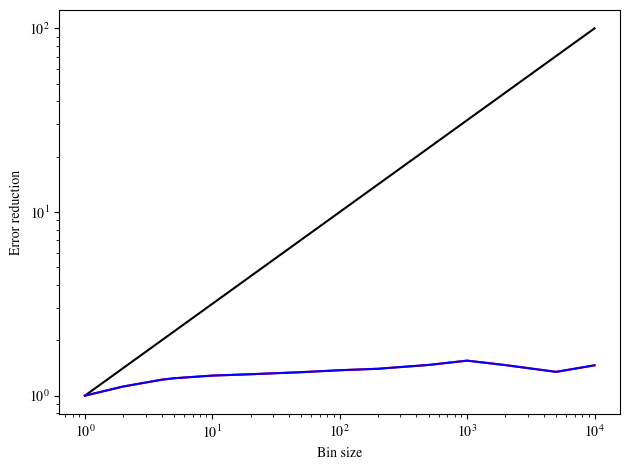

In [3]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [45]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

jackknife(jax.vmap(lambda x: model.observe(x, 2))(conf[:10000])), jackknife(jax.vmap(lambda x: model.observe(x, 2))(conf[:10000:2])), jackknife(jax.vmap(lambda x: model.observe(x, 2))(conf[:10000:4]))

((np.complex64(0.81456065+0.0032533237j),
  np.complex128(0.0047903707597285895+0.010936575857128017j)),
 (np.complex64(0.81508267+0.005752491j),
  np.complex128(0.00487330371989042+0.011235558982331357j)),
 (np.complex64(0.8160758+0.00090878934j),
  np.complex128(0.004608613438904285+0.01221935823559761j)))

(12800000, 1)
jack bin size 1: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0021403211503803307+0.002233860700703728j))
bin size 1: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0021403037816850965+0.002233859680766296j))
jack bin size 2: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0024146236906152905+0.0025697814482867156j))
bin size 2: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.002414614069980552+0.0025697813075497558j))
jack bin size 4: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.002658508671989928+0.002910356901416582j))
bin size 4: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0026584869827771308+0.0029103562671948958j))
jack bin size 5: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0027044985350773427+0.002995745424484831j))
bin size 5: (np.complex64(0.2071349-0.0013013339j), np.complex128(0.0027045002270645402+0.0029957449710295864j))
jack bin size 10: (np.complex64(0.2071349-0.0013013339j), np.complex

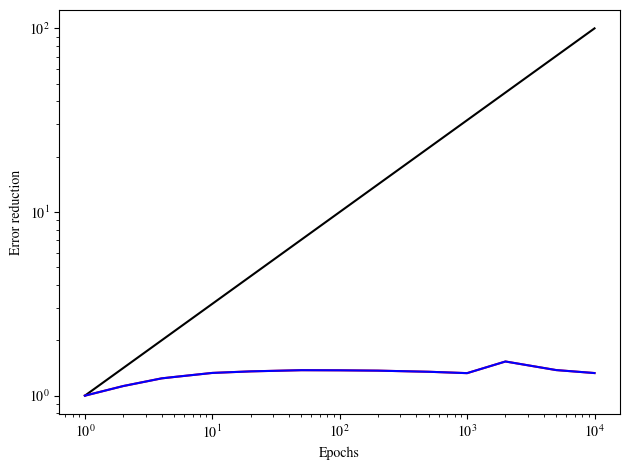

In [ ]:
with open("u1_2d_obc/config/c_1x1_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

print(conf.shape)
conf = conf.reshape((64, 200000)).T

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [35]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

In [23]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(10000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.0782414898276329 (np.complex64(0.82558185+0.0019577409j), np.complex128(0.011032144647378265+0.0299426709339833j))
Epoch 100: 3.7089655961608514e-05 (np.complex64(0.81851214+0.0019577409j), np.complex128(0.0002765449073977058+0.0299426709339833j))
Epoch 200: 8.15301882539643e-06 (np.complex64(0.8184082+0.0019577409j), np.complex128(0.00010420377085416822+0.0299426709339833j))
Epoch 300: 2.9782378987874836e-05 (np.complex64(0.8185766+0.0019577409j), np.complex128(0.00033254576786505+0.0299426709339833j))
Epoch 400: 6.120706984802382e-06 (np.complex64(0.8185583+0.0019577409j), np.complex128(0.0001119021987501891+0.0299426709339833j))
Epoch 500: 1.1453385013737716e-05 (np.complex64(0.8187592+0.0019577409j), np.complex128(0.00019858927225338218+0.0299426709339833j))
Epoch 600: 2.2401497972168727e-06 (np.complex64(0.81859434+0.0019577409j), np.complex128(5.0497351852135604e-05+0.0299426709339833j))
Epoch 700: 3.3362850899720797e-06 (np.complex64(0.8187763+0.0019577409j), np.compl

In [36]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:2]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %200 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(5000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.0782414898276329 (np.complex64(0.82558185+0.0019577409j), np.complex128(0.011032144647378265+0.0299426709339833j))
Epoch 200: 3.0453617000603117e-05 (np.complex64(0.8188113+0.0019577409j), np.complex128(0.0003604263147789619+0.0299426709339833j))
Epoch 400: 1.4693189768877346e-05 (np.complex64(0.81831956+0.0019577409j), np.complex128(0.00011447850080638385+0.0299426709339833j))
Epoch 600: 1.798320226953365e-05 (np.complex64(0.8183305+0.0019577409j), np.complex128(0.00022765239834336728+0.0299426709339833j))
Epoch 800: 5.331441570888273e-06 (np.complex64(0.81850064+0.0019577409j), np.complex128(8.616354336295215e-05+0.0299426709339833j))
Epoch 1000: 1.973097096197307e-05 (np.complex64(0.8183284+0.0019577409j), np.complex128(0.00029072719927082305+0.0299426709339833j))
Epoch 1200: 6.8839549385302234e-06 (np.complex64(0.8184001+0.0019577409j), np.complex128(0.00010458766705629434+0.0299426709339833j))
Epoch 1400: 9.420818969374523e-06 (np.complex64(0.8185824+0.0019577409j), np.

In [34]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:4]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %400 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(2500//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

    epochs+=1

Epoch 0: 0.0782414898276329 (np.complex64(0.82558185+0.0019577409j), np.complex128(0.011032144647378265+0.0299426709339833j))
Epoch 400: 6.542236224049702e-05 (np.complex64(0.81840605+0.0019577409j), np.complex128(0.00021412507217872268+0.0299426709339833j))
Epoch 800: 4.088349669473246e-05 (np.complex64(0.81864214+0.0019577409j), np.complex128(0.00023322751187000138+0.0299426709339833j))
Epoch 1200: 4.031942080473527e-05 (np.complex64(0.8186091+0.0019577409j), np.complex128(0.0001942578530237677+0.0299426709339833j))
Epoch 1600: 3.792357529164292e-05 (np.complex64(0.81865036+0.0019577409j), np.complex128(0.00017223229010083469+0.0299426709339833j))
Epoch 2000: 4.179403549642302e-05 (np.complex64(0.81861067+0.0019577409j), np.complex128(0.0002470119370112692+0.0299426709339833j))
Epoch 2400: 5.0998845836147666e-05 (np.complex64(0.81837505+0.0019577409j), np.complex128(0.0003616732915954512+0.0299426709339833j))
Epoch 2800: 3.50825757777784e-05 (np.complex64(0.8188626+0.0019577409j), np

## acceptancte rate 0.9

jack bin size 1: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0007544583014665821+0.0016665228432521473j))
bin size 1: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0007548600045034882+0.0016665439587164486j))
jack bin size 2: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0010514557247945913+0.002336366378920034j))
bin size 2: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0010514235433370107+0.002336375239979492j))
jack bin size 4: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0014534038042608541+0.0032614921489406163j))
bin size 4: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0014534422330410792+0.0032614867562155616j))
jack bin size 5: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0016075383392158968+0.0036243840125695127j))
bin size 5: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0016075947495615174+0.0036244152832053764j))
jack bin size 10: (np.complex64(0.8153891-0.021598026j), np.complex128(0.0021656899944

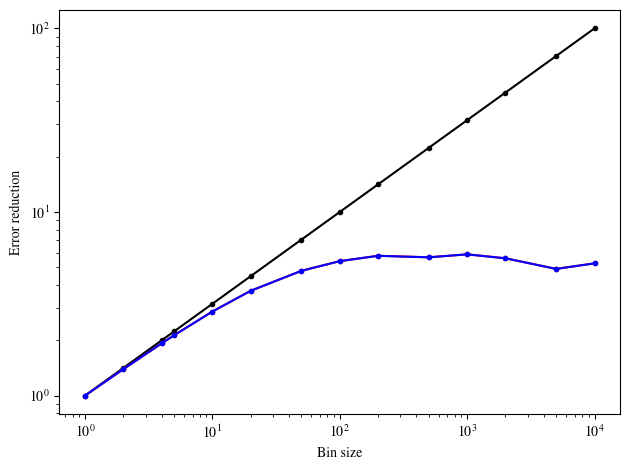

In [4]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

jack bin size 1: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008064339322462795+0.01661459614006134j))
bin size 1: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008064304095247098+0.01661459775699395j))
jack bin size 2: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008083154208966324+0.016687290354608055j))
bin size 2: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008083137476253346+0.01668728942696719j))
jack bin size 4: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007775881270466398+0.01722252944027777j))
bin size 4: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007775877659169743+0.017222531343678255j))
jack bin size 5: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008103117005646662+0.01664522288380143j))
bin size 5: (np.complex64(0.8119221-0.006802482j), np.complex128(0.00810309984877533+0.016645221241561217j))
jack bin size 10: (np.complex64(0.8119221-0.006802482j), np.complex128(0.007950403406222868+0.016219513329

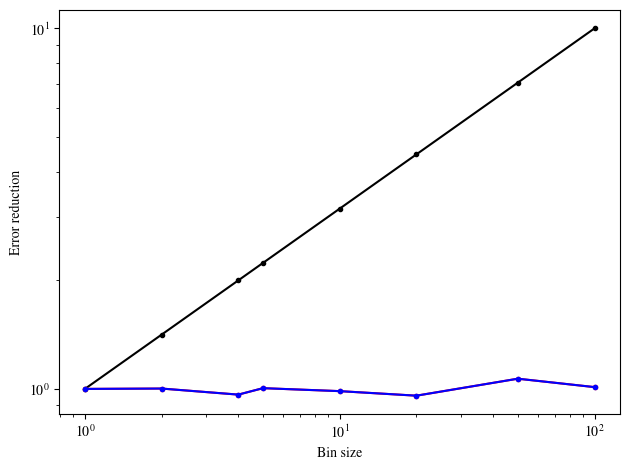

In [5]:
obs = jax.vmap(lambda x: model.observe(x, V))(conf[-100000::100])

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100:
    jac, bi = jackknife(obs, Bs=i), bin(obs, Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.1003413274884224 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.00015707100101280957 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8186479-0.006802482j), np.complex128(0.0003365394364560968+0.016092795843159265j)) <f>: (np.float32(-0.0067261895), np.complex128(0.008486941339214547+0j))
Epoch 200: <Test loss>: 9.066204074770212e-05 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8187687-0.006802482j), np.complex128(0.0002610274546947148+0.016092795843159265j)) <f>: (np.float32(-0.006846702), np.complex128(0.008537124370005488+0j))
Epoch 300: <Test loss>: 7.445619121426716e-05 <O>: (n

In [9]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.1003413274884224 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.00013494420272763819 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.81867343-0.006802482j), np.complex128(0.00032857166753016504+0.016092795843159265j)) <f>: (np.float32(-0.006751621), np.complex128(0.008535205222004079+0j))
Epoch 400: <Test loss>: 9.020504512591287e-05 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.81870455-0.006802482j), np.complex128(0.00025256294701329543+0.016092795843159265j)) <f>: (np.float32(-0.006782597), np.complex128(0.008556997852905325+0j))
Epoch 600: <Test loss>: 7.459449989255518e-05 <O>:

In [10]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.1003413274884224 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0001828517997637391 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.818625-0.006802482j), np.complex128(0.0003570609870162453+0.016092795843159265j)) <f>: (np.float32(-0.006702497), np.complex128(0.008540281678007806+0j))
Epoch 800: <Test loss>: 0.00011657412687782198 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.818712-0.006802482j), np.complex128(0.00030240856017489106+0.016092795843159265j)) <f>: (np.float32(-0.0067905807), np.complex128(0.008552417675787207+0j))
Epoch 1200: <Test loss>: 0.00011329962580930442 <O>: (

In [12]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.1003413274884224 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.00018033191736321896 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.81873375-0.006802482j), np.complex128(0.0003604373833711832+0.016092795843159265j)) <f>: (np.float32(-0.006811833), np.complex128(0.008533465708691327+0j))
Epoch 1600: <Test loss>: 0.0001386531803291291 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.81868076-0.006802482j), np.complex128(0.0003145794129194824+0.016092795843159265j)) <f>: (np.float32(-0.0067586224), np.complex128(0.008527230253735928+0j))
Epoch 2400: <Test loss>: 0.0001225435407832265 <O>

In [14]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [15]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.1003413274884224 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00020814643357880414 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.81877905-0.006802482j), np.complex128(0.00040902672717324994+0.016092795843159265j)) <f>: (np.float32(-0.006857204), np.complex128(0.008471914440810071+0j))
Epoch 3200: <Test loss>: 0.00014953948266338557 <O>: (np.complex64(0.8119221-0.006802482j), np.complex128(0.008607798948811474+0.016092795843159265j)) <O-f>: (np.complex64(0.8188561-0.006802482j), np.complex128(0.0003192732571852236+0.016092795843159265j)) <f>: (np.float32(-0.0069341743), np.complex128(0.008525038101603172+0j))
Epoch 4800: <Test loss>: 0.0001315802219323814 <

## acceptance rate 0.95

jack bin size 1: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0007858813464481215+0.00167867980674745j))
bin size 1: (np.complex64(0.81015176+0.014589203j), np.complex128(0.000785428510663828+0.0016786981903800355j))


jack bin size 2: (np.complex64(0.81015176+0.014589203j), np.complex128(0.001105021415623941+0.0023670660759158887j))
bin size 2: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0011051070135157388+0.002367078203007505j))
jack bin size 4: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0015510171241164626+0.0033330175476751953j))
bin size 4: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0015510318122480134+0.003333026329174372j))
jack bin size 5: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0017283148262720288+0.0037187248430714855j))
bin size 5: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0017283239382734179+0.003718727958090609j))
jack bin size 10: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0024042385263558655+0.005207594302193703j))
bin size 10: (np.complex64(0.81015176+0.014589203j), np.complex128(0.002404285634243167+0.005207600507804442j))
jack bin size 20: (np.complex64(0.81015176+0.014589203j), np.complex128(0.0032933

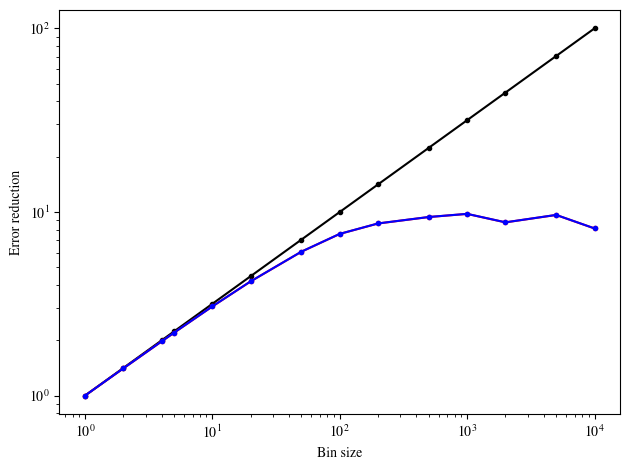

In [14]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=2
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [15]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [16]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0002556348335929215 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8189765-0.009052431j), np.complex128(0.000577016178497404+0.02958299560257169j)) <f>: (np.float32(0.013369947), np.complex128(0.008080773607211428+0j))
Epoch 200: <Test loss>: 0.00026994739891961217 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8189102-0.009052431j), np.complex128(0.0006310406768075596+0.02958299560257169j)) <f>: (np.float32(0.01343664), np.complex128(0.008070756182384401+0j))
Epoch 300: <Test loss>: 0.00026630182401277125 <O>: (np.complex

In [17]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [18]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0002800355723593384 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.81903887-0.009052431j), np.complex128(0.0006344328038838205+0.02958299560257169j)) <f>: (np.float32(0.013308062), np.complex128(0.008070325871039823+0j))
Epoch 400: <Test loss>: 0.00027723799576051533 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8188297-0.009052431j), np.complex128(0.0005192368267808033+0.02958299560257169j)) <f>: (np.float32(0.013516911), np.complex128(0.00815795055579268+0j))
Epoch 600: <Test loss>: 0.0002794223837554455 <O>: (np.comple

In [19]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00028011834365315735 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.81901395-0.009052431j), np.complex128(0.0006112733762766533+0.02958299560257169j)) <f>: (np.float32(0.013332867), np.complex128(0.008062147925722343+0j))
Epoch 800: <Test loss>: 0.0003020231379196048 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8190506-0.009052431j), np.complex128(0.0006328105098170556+0.02958299560257169j)) <f>: (np.float32(0.013295803), np.complex128(0.00806411528077297+0j))
Epoch 1200: <Test loss>: 0.00029251619707793 <O>: (np.complex

In [21]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [22]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0002928934118244797 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8188643-0.009052431j), np.complex128(0.000659818572570491+0.02958299560257169j)) <f>: (np.float32(0.013482633), np.complex128(0.008057066902735006+0j))
Epoch 1600: <Test loss>: 0.00028754500090144575 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8189068-0.009052431j), np.complex128(0.0006027693356433606+0.02958299560257169j)) <f>: (np.float32(0.013440087), np.complex128(0.008083498574098675+0j))
Epoch 2400: <Test loss>: 0.00028071858105249703 <O>: (np.comp

In [23]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [24]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00023612137010786682 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8188945-0.009052431j), np.complex128(0.0005886418158583984+0.02958299560257169j)) <f>: (np.float32(0.013453266), np.complex128(0.008096433286567187+0j))
Epoch 3200: <Test loss>: 0.0002242360933450982 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.81896305-0.009052431j), np.complex128(0.0005557903610064107+0.02958299560257169j)) <f>: (np.float32(0.013383938), np.complex128(0.008094299490336113+0j))
Epoch 4800: <Test loss>: 0.00022798412828706205 <O>: (np.c

### l3, w32

In [15]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [16]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0005720353219658136 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8186422-0.009052431j), np.complex128(0.0008869942285692459+0.02958299560257169j)) <f>: (np.float32(0.013704418), np.complex128(0.008062875598444189+0j))
Epoch 200: <Test loss>: 0.0005915125366300344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8186567-0.009052431j), np.complex128(0.000858956881884727+0.02958299560257169j)) <f>: (np.float32(0.013690135), np.complex128(0.008091433961842205+0j))
Epoch 300: <Test loss>: 0.0005959373083896935 <O>: (np.complex6

In [17]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [18]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0007122118840925395 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.818647-0.009052431j), np.complex128(0.0009999888244267945+0.02958299560257169j)) <f>: (np.float32(0.0136999795), np.complex128(0.008035425997178134+0j))
Epoch 400: <Test loss>: 0.0007257314864546061 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8184424-0.009052431j), np.complex128(0.0009273455585332973+0.02958299560257169j)) <f>: (np.float32(0.013904261), np.complex128(0.008068434124940073+0j))
Epoch 600: <Test loss>: 0.0007300499710254371 <O>: (np.complex

In [19]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0006242881645448506 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8187012-0.009052431j), np.complex128(0.0009396947456448228+0.02958299560257169j)) <f>: (np.float32(0.013645184), np.complex128(0.008012479441751453+0j))
Epoch 800: <Test loss>: 0.0006384490407072008 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.81862205-0.009052431j), np.complex128(0.0009272224402668135+0.02958299560257169j)) <f>: (np.float32(0.013724485), np.complex128(0.008049336014368675+0j))
Epoch 1200: <Test loss>: 0.0006505060591734946 <O>: (np.compl

In [21]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [22]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0005710083642043173 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8187696-0.009052431j), np.complex128(0.0008782507384480726+0.02958299560257169j)) <f>: (np.float32(0.013577666), np.complex128(0.008004132518040406+0j))
Epoch 1600: <Test loss>: 0.0006007470656186342 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8187746-0.009052431j), np.complex128(0.0009158947351560378+0.02958299560257169j)) <f>: (np.float32(0.013572683), np.complex128(0.00803011763989555+0j))
Epoch 2400: <Test loss>: 0.0006224368698894978 <O>: (np.comple

In [23]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [24]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_2x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_10min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.08073682337999344 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0005691909464076161 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.818674-0.009052431j), np.complex128(0.0010192949864737556+0.02958299560257169j)) <f>: (np.float32(0.013671932), np.complex128(0.008005397065057727+0j))
Epoch 3200: <Test loss>: 0.0005432081525214016 <O>: (np.complex64(0.8323471-0.009052431j), np.complex128(0.008383196217203952+0.02958299560257169j)) <O-f>: (np.complex64(0.8187571-0.009052431j), np.complex128(0.0009658130077582606+0.02958299560257169j)) <f>: (np.float32(0.013589449), np.complex128(0.008019370512576183+0j))
Epoch 4800: <Test loss>: 0.0005412720493040979 <O>: (np.compl

# A=4

In [46]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

jackknife(jax.vmap(lambda x: model.observe(x, 4))(conf[:10000])), jackknife(jax.vmap(lambda x: model.observe(x, 4))(conf[:10000:2])), jackknife(jax.vmap(lambda x: model.observe(x, 4))(conf[:10000:4])), jackknife(jax.vmap(lambda x: model.observe(x, 4))(conf[:10000:8]))

((np.complex64(0.66952693-0.005553248j),
  np.complex128(0.007208037792214021+0.012341813707006214j)),
 (np.complex64(0.66907-0.0083821565j),
  np.complex128(0.007659128751321676+0.014126573172272245j)),
 (np.complex64(0.67011565-0.015914975j),
  np.complex128(0.009856007411144674+0.016237387200817466j)),
 (np.complex64(0.6692987-0.025997235j),
  np.complex128(0.013297619701008309+0.020012585098598466j)))

In [42]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*1, 4)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

index = jnp.array(
    [(-i, -j) for i, j in product(*list(map(lambda y: range(y), model.shape)))])

@jax.jit
def g(x, p):
    def g_(x, p, ind):
        return g1.apply(p, jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V))[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))
#j2 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[1], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    '''
    # diagonal sum (Stein's identity)
    def diag_(ind):
        return g1_grad(jnp.roll(x.reshape(model.shape), ind, axis=(0, 1)).reshape(V), p)
    j = jax.vmap(diag_)(index)[:, 0].sum()
    '''
    '''
    dg = jnp.trace(j1(x, p) + 1j*j2(x, p))
    ds = dS(x)
    gx1, gx2, _ = g1.apply(p, x)

    return dg - (gx1+1j*gx2)@ds
    '''
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    #return jnp.abs(jnp.sin(x)[0] - f(x, p)[0] - y[0])**2
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2
'''
@jax.jit
def Loss(x,p):
    _, _, y = g1.apply(p,x)
    #return (jnp.abs(model.observe(x, 1) - f(x,p)[0])**2)
    return (jnp.abs(model.observe(x, 1) - f(x,p) - y[0])**2)
'''

Loss_grad = jax.jit(jax.grad(lambda x, p: Loss(x, p), argnums=1))

sched = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.8,
    end_value=1e-5)

In [39]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %100 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(10000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.2533715069293976 (np.complex64(0.6808411-0.0060010287j), np.complex128(0.021727493536345326+0.03852877874041819j))
Epoch 100: 0.001006853999570012 (np.complex64(0.6710337-0.0060010287j), np.complex128(0.0015361509876114174+0.03852877874041819j))
Epoch 200: 0.000460760056739673 (np.complex64(0.6693487-0.0060010287j), np.complex128(0.0008976372667205024+0.03852877874041819j))
Epoch 300: 0.00044096464989706874 (np.complex64(0.66893643-0.0060010287j), np.complex128(0.0009231465342556242+0.03852877874041819j))
Epoch 400: 0.00026828981935977936 (np.complex64(0.66891176-0.0060010287j), np.complex128(0.0007017402471627444+0.03852877874041819j))
Epoch 500: 0.0004198154783807695 (np.complex64(0.66779745-0.0060010287j), np.complex128(0.0009513824178665184+0.03852877874041819j))
Epoch 600: 0.00036261597415432334 (np.complex64(0.66880643-0.0060010287j), np.complex128(0.0008680319223299144+0.03852877874041819j))
Epoch 700: 0.0002555550017859787 (np.complex64(0.66945404-0.0060010287j), np.

In [41]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:2]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %200 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(5000//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)
    
    epochs+=1

Epoch 0: 0.2533715069293976 (np.complex64(0.6808411-0.0060010287j), np.complex128(0.021727493536345326+0.03852877874041819j))
Epoch 200: 0.0008367511327378452 (np.complex64(0.6683652-0.0060010287j), np.complex128(0.0011621354545253474+0.03852877874041819j))
Epoch 400: 0.0004081444931216538 (np.complex64(0.6703099-0.0060010287j), np.complex128(0.0007180541469206233+0.03852877874041819j))
Epoch 600: 0.0003165207745041698 (np.complex64(0.66971153-0.0060010287j), np.complex128(0.0008353698070067542+0.03852877874041819j))
Epoch 800: 0.00038527787546627223 (np.complex64(0.66958207-0.0060010287j), np.complex128(0.0006212387882347894+0.03852877874041819j))
Epoch 1000: 0.00038843907532282174 (np.complex64(0.67004544-0.0060010287j), np.complex128(0.0005893411986539938+0.03852877874041819j))
Epoch 1200: 0.00030975110712461174 (np.complex64(0.66975534-0.0060010287j), np.complex128(0.0004935213472496284+0.03852877874041819j))
Epoch 1400: 0.00027625917573459446 (np.complex64(0.6696896-0.0060010287j)

In [43]:
opt = getattr(optax, 'adam')(sched, 0.9, 0.999)
opt = optax.adam(1e-3)
opt_state = opt.init(g_params)
opt_update_jit = jax.jit(opt.update)

conf_train = conf[:10000:4]
conf_test = conf[-1000:]

start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)
    
    if epochs %400 ==0:
        ls = jnp.mean(jax.vmap(lambda y: Loss(y, g_params))(conf_test))
        ms = jackknife(jax.vmap(lambda y: model.observe(y, V) - f(y, g_params))(conf_test))
        print(f"Epoch {epochs}: {ls} {ms}")
    for i in range(2500//100):
        grads = jax.vmap(lambda y: Loss_grad(y, g_params))(conf_train[i*100: (i+1)*100])
        #grads = Loss_grad(jnp.zeros(V) ,g_params)
        grad = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
    
        updates, opt_state = opt_update_jit(grad, opt_state)
        g_params = optax.apply_updates(g_params, updates)

    epochs+=1

Epoch 0: 0.2533715069293976 (np.complex64(0.6808411-0.0060010287j), np.complex128(0.021727493536345326+0.03852877874041819j))
Epoch 400: 0.0011533434735611081 (np.complex64(0.669337-0.0060010287j), np.complex128(0.0017103848375672052+0.03852877874041819j))
Epoch 800: 0.0006657402846030891 (np.complex64(0.6694185-0.0060010287j), np.complex128(0.001223301700316156+0.03852877874041819j))
Epoch 1200: 0.000528025149833411 (np.complex64(0.6696557-0.0060010287j), np.complex128(0.0009409343645432739+0.03852877874041819j))
Epoch 1600: 0.0004526640987023711 (np.complex64(0.6698114-0.0060010287j), np.complex128(0.0010505535155008031+0.03852877874041819j))
Epoch 2000: 0.00044502108357846737 (np.complex64(0.6694447-0.0060010287j), np.complex128(0.000810268015898161+0.03852877874041819j))
Epoch 2400: 0.0004485095851123333 (np.complex64(0.6699958-0.0060010287j), np.complex128(0.0010180174996695388+0.03852877874041819j))
Epoch 2800: 0.0003679170913528651 (np.complex64(0.6701354-0.0060010287j), np.comp

## acceptance rate 0.9

jack bin size 1: (np.complex64(0.6672563-0.02573132j), np.complex128(0.0012570259126479487+0.0019897556497163417j))
bin size 1: (np.complex64(0.6672563-0.02573132j), np.complex128(0.0012578559163499378+0.001989750053127259j))
jack bin size 2: (np.complex64(0.6672563-0.02573132j), np.complex128(0.001749806872811494+0.002785610545502258j))
bin size 2: (np.complex64(0.6672563-0.02573132j), np.complex128(0.001750028375060165+0.002785609161752196j))
jack bin size 4: (np.complex64(0.6672563-0.02573132j), np.complex128(0.0024161924265528045+0.00388098827896311j))
bin size 4: (np.complex64(0.6672563-0.02573132j), np.complex128(0.0024161828223762494+0.0038809801766798335j))
jack bin size 5: (np.complex64(0.6672563-0.02573132j), np.complex128(0.002671418047596298+0.004309172148682367j))
bin size 5: (np.complex64(0.6672563-0.02573132j), np.complex128(0.0026715032666337663+0.004309161482631433j))
jack bin size 10: (np.complex64(0.6672563-0.02573132j), np.complex128(0.003588340327139785+0.005899802

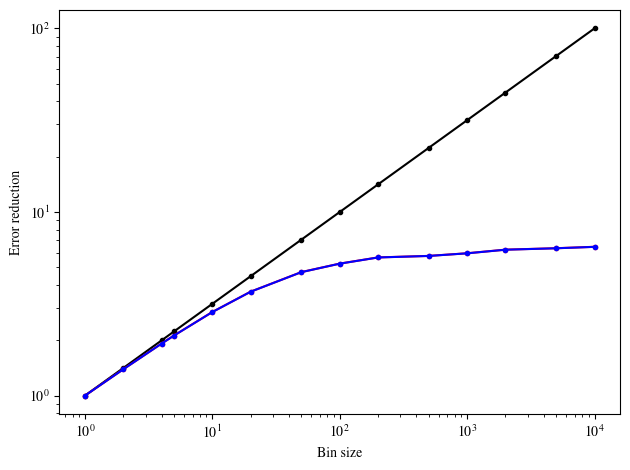

In [3]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [17]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [18]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.287528932094574 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0010501234792172909 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6704243-0.005674377j), np.complex128(0.000894907732849646+0.01882119913185093j)) <f>: (np.float32(-0.017649014), np.complex128(0.011671722285159305+0j))
Epoch 200: <Test loss>: 0.0006939317681826651 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6700966-0.005674377j), np.complex128(0.0007446144549893037+0.01882119913185093j)) <f>: (np.float32(-0.017321656), np.complex128(0.011564217520752509+0j))
Epoch 300: <Test loss>: 0.0005982792936265469 <O>: (np.complex64(0.

In [19]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.287528932094574 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0010110968723893166 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6707859-0.005674377j), np.complex128(0.0009025073838675207+0.01882119913185093j)) <f>: (np.float32(-0.018010568), np.complex128(0.011712651592271322+0j))
Epoch 400: <Test loss>: 0.0007490477291867137 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6703359-0.005674377j), np.complex128(0.0007687722759578596+0.01882119913185093j)) <f>: (np.float32(-0.017561255), np.complex128(0.01165361876212962+0j))
Epoch 600: <Test loss>: 0.0006142354104667902 <O>: (np.complex64(0.

In [21]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [22]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.287528932094574 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0010189289459958673 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.67080486-0.005674377j), np.complex128(0.0008759101593479935+0.01882119913185093j)) <f>: (np.float32(-0.018029932), np.complex128(0.011714864042109011+0j))
Epoch 800: <Test loss>: 0.0007302433950826526 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.670946-0.005674377j), np.complex128(0.0008676344678951963+0.01882119913185093j)) <f>: (np.float32(-0.018171342), np.complex128(0.011738845780487275+0j))
Epoch 1200: <Test loss>: 0.0006321006221696734 <O>: (np.complex64(

In [23]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [24]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.287528932094574 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0010283676674589515 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.67059153-0.005674377j), np.complex128(0.0009642833219702522+0.01882119913185093j)) <f>: (np.float32(-0.017815664), np.complex128(0.01166523818331848+0j))
Epoch 1600: <Test loss>: 0.0006168995168991387 <O>: (np.complex64(0.6527751-0.005674377j), np.complex128(0.01134928512321766+0.01882119913185093j)) <O-f>: (np.complex64(0.6704079-0.005674377j), np.complex128(0.0006573107276956989+0.01882119913185093j)) <f>: (np.float32(-0.017631654), np.complex128(0.011490969192961026+0j))
Epoch 2400: <Test loss>: 0.0005702366470359266 <O>: (np.complex64

In [4]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.2875290811061859 <O>: (np.complex64(0.6527751-0.005674383j), np.complex128(0.01134929730184062+0.01882120116162142j)) <O-f>: (np.complex64(0.6527751-0.005674383j), np.complex128(0.01134929730184062+0.01882120116162142j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0013954492751508951 <O>: (np.complex64(0.6527751-0.005674383j), np.complex128(0.01134929730184062+0.01882120116162142j)) <O-f>: (np.complex64(0.67222065-0.005674383j), np.complex128(0.0011313717454863679+0.01882120116162142j)) <f>: (np.float32(-0.019444816), np.complex128(0.011854288977293341+0j))
Epoch 3200: <Test loss>: 0.0011625359766185284 <O>: (np.complex64(0.6527751-0.005674383j), np.complex128(0.01134929730184062+0.01882120116162142j)) <O-f>: (np.complex64(0.671549-0.005674383j), np.complex128(0.001070644310704078+0.01882120116162142j)) <f>: (np.float32(-0.01877317), np.complex128(0.011767488886803385+0j))
Epoch 4800: <Test loss>: 0.0010734895477071404 <O>: (np.complex64

## acceptance rate 0.95

jack bin size 1: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0013166798631763438+0.002009274465009969j))
bin size 1: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0013167431433142199+0.0020092633975312803j))
jack bin size 2: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0018525201028294286+0.002831834274972119j))
bin size 2: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0018523140964558135+0.0028318428697372863j))
jack bin size 4: (np.complex64(0.6500853+0.017721476j), np.complex128(0.002598875029402924+0.003984958891160889j))
bin size 4: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0025989039090845278+0.003984950243620451j))
jack bin size 5: (np.complex64(0.6500853+0.017721476j), np.complex128(0.0028948193135412163+0.00444458429290129j))
bin size 5: (np.complex64(0.6500853+0.017721476j), np.complex128(0.002894901900174136+0.004444593650924079j))
jack bin size 10: (np.complex64(0.6500853+0.017721476j), np.complex128(0.004022445179681236+0

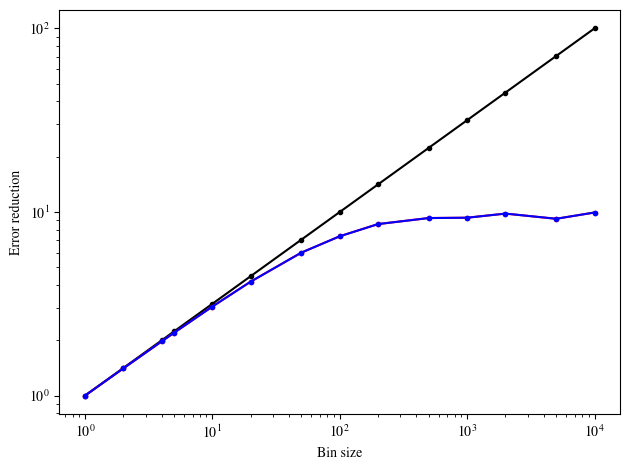

In [3]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=4
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [26]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [27]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.001649118261411786 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67055875-0.018825065j), np.complex128(0.0018431989371155344+0.027726839498651564j)) <f>: (np.float32(0.021761123), np.complex128(0.01497038248974505+0j))
Epoch 200: <Test loss>: 0.0011089759645983577 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67042565-0.018825065j), np.complex128(0.0014329317030192423+0.027726839498651564j)) <f>: (np.float32(0.021893913), np.complex128(0.015177173477831297+0j))
Epoch 300: <Test loss>: 0.0008871738682501018 <O>: (

In [28]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [29]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0017775254091247916 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6707764-0.018825065j), np.complex128(0.0017212064320915436+0.027726839498651564j)) <f>: (np.float32(0.021543331), np.complex128(0.014983991086017334+0j))
Epoch 400: <Test loss>: 0.0011813802411779761 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6702022-0.018825065j), np.complex128(0.0015889503925682145+0.027726839498651564j)) <f>: (np.float32(0.022118118), np.complex128(0.015265047316912205+0j))
Epoch 600: <Test loss>: 0.0008690865361131728 <O>: (

In [30]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [31]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.001860674237832427 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67059875-0.018825065j), np.complex128(0.001955308362747023+0.027726839498651564j)) <f>: (np.float32(0.0217212), np.complex128(0.014854390240020545+0j))
Epoch 800: <Test loss>: 0.001017464092001319 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6699498-0.018825065j), np.complex128(0.0014037401780879746+0.027726839498651564j)) <f>: (np.float32(0.022369841), np.complex128(0.01526732167474994+0j))
Epoch 1200: <Test loss>: 0.000798444205429405 <O>: (np.co

In [32]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [33]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0021237514447420835 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67006564-0.018825065j), np.complex128(0.0020920722688146454+0.027726839498651564j)) <f>: (np.float32(0.022254443), np.complex128(0.014701488643645993+0j))
Epoch 1600: <Test loss>: 0.0013174449559301138 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67024255-0.018825065j), np.complex128(0.0016278034981869036+0.027726839498651564j)) <f>: (np.float32(0.022077603), np.complex128(0.01518138829626062+0j))
Epoch 2400: <Test loss>: 0.0010411167750135064 <O>

In [34]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [35]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0018104494083672762 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6703713-0.018825065j), np.complex128(0.0018713191238083106+0.027726839498651564j)) <f>: (np.float32(0.021948505), np.complex128(0.014868415954129204+0j))
Epoch 3200: <Test loss>: 0.0011374757159501314 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6703176-0.018825065j), np.complex128(0.0014883403779451683+0.027726839498651564j)) <f>: (np.float32(0.022002755), np.complex128(0.015102237395874641+0j))
Epoch 4800: <Test loss>: 0.0010282412404194474 <O>

### l3, w32

In [4]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0008039757376536727 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6702182-0.018825065j), np.complex128(0.0016695124908896566+0.027726839498651564j)) <f>: (np.float32(0.022102047), np.complex128(0.01509830877508487+0j))
Epoch 200: <Test loss>: 0.0006497204885818064 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.670233-0.018825065j), np.complex128(0.0013847634731642062+0.027726839498651564j)) <f>: (np.float32(0.022087274), np.complex128(0.0151977076510267+0j))
Epoch 300: <Test loss>: 0.0005723331705667078 <O>: (np.c

In [6]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0008818815113045275 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6705492-0.018825065j), np.complex128(0.0016967329818112806+0.027726839498651564j)) <f>: (np.float32(0.021771332), np.complex128(0.015123590581464088+0j))
Epoch 400: <Test loss>: 0.0007200285326689482 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6704616-0.018825065j), np.complex128(0.001467664881979169+0.027726839498651564j)) <f>: (np.float32(0.021858193), np.complex128(0.015282686022498927+0j))
Epoch 600: <Test loss>: 0.0006641261861659586 <O>: (n

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0008614002726972103 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6701158-0.018825065j), np.complex128(0.0015176761434421157+0.027726839498651564j)) <f>: (np.float32(0.022204207), np.complex128(0.01522318837491426+0j))
Epoch 800: <Test loss>: 0.000785611686296761 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6697963-0.018825065j), np.complex128(0.001518681641000231+0.027726839498651564j)) <f>: (np.float32(0.022523789), np.complex128(0.015369764191546464+0j))
Epoch 1200: <Test loss>: 0.0006817683461122215 <O>: (np

In [10]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0010192126501351595 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6704326-0.018825065j), np.complex128(0.0016173750448349848+0.027726839498651564j)) <f>: (np.float32(0.02188714), np.complex128(0.01524040996266461+0j))
Epoch 1600: <Test loss>: 0.0009417771943844855 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.67028207-0.018825065j), np.complex128(0.0016325482135756328+0.027726839498651564j)) <f>: (np.float32(0.022037588), np.complex128(0.01522074859078132+0j))
Epoch 2400: <Test loss>: 0.0009006714099086821 <O>: (

In [12]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_4x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_20min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.23407065868377686 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0012126966612413526 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6703435-0.018825065j), np.complex128(0.0020412116752609112+0.027726839498651564j)) <f>: (np.float32(0.02197701), np.complex128(0.015042369315174949+0j))
Epoch 3200: <Test loss>: 0.0010348799405619502 <O>: (np.complex64(0.69231987-0.018825065j), np.complex128(0.015639439499285437+0.027726839498651564j)) <O-f>: (np.complex64(0.6702213-0.018825065j), np.complex128(0.0018066959251461115+0.027726839498651564j)) <f>: (np.float32(0.02209849), np.complex128(0.01517376143363207+0j))
Epoch 4800: <Test loss>: 0.0009778711246326566 <O>: (

# A=8

In [64]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=8
conf=conf[:,:V]

jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000:2])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000:4])), jackknife(jax.vmap(lambda x: model.observe(x, 8))(conf[:10000:8]))

((np.complex64(0.44980034+0.0023750458j),
  np.complex128(0.00870124306000743+0.013617663556417792j)),
 (np.complex64(0.44608104-0.0036469835j),
  np.complex128(0.009183614589011374+0.013622748933584993j)),
 (np.complex64(0.4407123-0.003842462j),
  np.complex128(0.013019280973821878+0.015361153287813067j)),
 (np.complex64(0.44936648-0.003316855j),
  np.complex128(0.01640039801145443+0.022330950406561044j)))

In [65]:
td= 8
bs=25
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=bs)

((np.complex64(0.44980034+0.0023750458j),
  np.complex128(0.00860545621312295+0.013359759601823153j)),
 (np.complex64(0.44608104-0.0036469835j),
  np.complex128(0.009341476153326969+0.01420252030988984j)),
 (np.complex64(0.4407123-0.003842462j),
  np.complex128(0.012032165426571699+0.015783683505364056j)),
 (np.complex64(0.44936648-0.003316855j),
  np.complex128(0.017847168026492+0.02014270145446062j)))

In [66]:
td= 8
bs=100
jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:2]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:4]), Bs=bs), jackknife(jax.vmap(lambda x: model.observe(x, td))(conf[:10000:8]), Bs=bs)

((np.complex64(0.44980034+0.0023750458j),
  np.complex128(0.008583671399559166+0.012681453534614947j)),
 (np.complex64(0.44608104-0.0036469835j),
  np.complex128(0.009253940894268453+0.013077817391604185j)),
 (np.complex64(0.4407123-0.003842462j),
  np.complex128(0.012559467332728235+0.015187808660363523j)),
 (np.complex64(0.44714952-0.006076773j),
  np.complex128(0.013983875365887233+0.02505240221481707j)))

## acceptance rate 0.9

jack bin size 1: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0017958897655476133+0.00218785984028918j))
bin size 1: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0017959592046880547+0.002187843314480767j))
jack bin size 2: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0024907122948722446+0.003050374256485539j))
bin size 2: (np.complex64(0.44578224-0.008827876j), np.complex128(0.00249069240896884+0.003050370471376784j))
jack bin size 4: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0034247949971170344+0.0042232619421198455j))
bin size 4: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0034247935401489427+0.004223261050507328j))
jack bin size 5: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0037808343271368617+0.004681170267792941j))
bin size 5: (np.complex64(0.44578224-0.008827876j), np.complex128(0.0037808775687905227+0.004681168140177949j))
jack bin size 10: (np.complex64(0.44578224-0.008827876j), np.complex128(0.005045838207

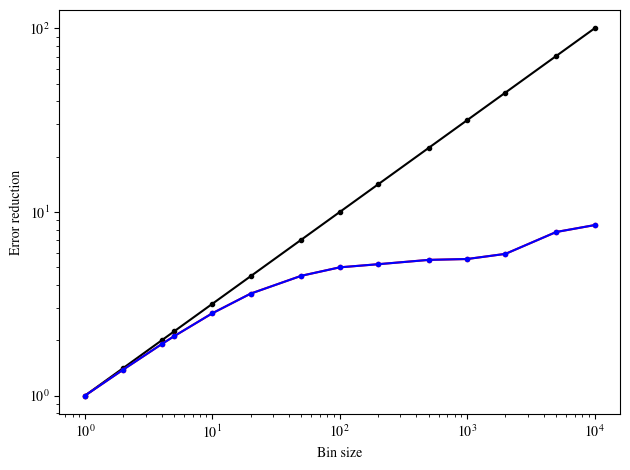

In [4]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=8
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [5]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [6]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.6791571974754333 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.015292538329958916 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44698536+0.022922255j), np.complex128(0.0036542074902566153+0.02070388839565939j)) <f>: (np.float32(-0.026650582), np.complex128(0.02002320080119243+0j))
Epoch 200: <Test loss>: 0.012202461250126362 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44646102+0.022922255j), np.complex128(0.003325011953736238+0.02070388839565939j)) <f>: (np.float32(-0.0261268), np.complex128(0.01969882520842969+0j))
Epoch 300: <Test loss>: 0.01011202484369278 <O>: (np.complex64(0.4

In [7]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [8]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.6791571974754333 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.014941453002393246 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44681224+0.022922255j), np.complex128(0.0035554885874300394+0.02070388839565939j)) <f>: (np.float32(-0.026477726), np.complex128(0.019541751418806173+0j))
Epoch 400: <Test loss>: 0.011513630859553814 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44642645+0.022922255j), np.complex128(0.003537370856006902+0.02070388839565939j)) <f>: (np.float32(-0.026091672), np.complex128(0.01979619329899298+0j))
Epoch 600: <Test loss>: 0.009529879316687584 <O>: (np.complex64

Epoch 800: <Test loss>: 0.00831890944391489 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44445664+0.022922255j), np.complex128(0.003292812435794565+0.02070388839565939j)) <f>: (np.float32(-0.02412222), np.complex128(0.01966824468617773+0j))
Epoch 1000: <Test loss>: 0.0073014977388083935 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4454265+0.022922255j), np.complex128(0.0031007966545716237+0.02070388839565939j)) <f>: (np.float32(-0.025092015), np.complex128(0.01966573588984802+0j))
Epoch 1200: <Test loss>: 0.0063715544529259205 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44502452+0.022922255j), np.complex128(0.002624890067959928+0.02070388839565939j)) <f>: (np.float32(-0.024689939), np.complex128(0.019752334018173893+0j))
Epoch 1400: <Test loss>: 0.0

In [9]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [10]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.6791571974754333 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.015250034630298615 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4477073+0.022922255j), np.complex128(0.003549116630408968+0.02070388839565939j)) <f>: (np.float32(-0.027372543), np.complex128(0.020033928138249488+0j))
Epoch 800: <Test loss>: 0.012363302521407604 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44689384+0.022922255j), np.complex128(0.003455386649733596+0.02070388839565939j)) <f>: (np.float32(-0.026558956), np.complex128(0.019865475455240564+0j))
Epoch 1200: <Test loss>: 0.009967634454369545 <O>: (np.complex64

Epoch 2000: <Test loss>: 0.007059745956212282 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44572157+0.022922255j), np.complex128(0.0029034509497546054+0.02070388839565939j)) <f>: (np.float32(-0.025386944), np.complex128(0.01994448224192152+0j))
Epoch 2400: <Test loss>: 0.006284023635089397 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4454113+0.022922255j), np.complex128(0.002734399738171475+0.02070388839565939j)) <f>: (np.float32(-0.025076626), np.complex128(0.019735608709309155+0j))
Epoch 2800: <Test loss>: 0.005917135626077652 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44567236+0.022922255j), np.complex128(0.0026483669009279838+0.02070388839565939j)) <f>: (np.float32(-0.025336938), np.complex128(0.01969832588488834+0j))
Epoch 3200: <Test loss>: 0

In [11]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [12]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.6791571974754333 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.01747167482972145 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44944194+0.022922255j), np.complex128(0.003771431810670548+0.02070388839565939j)) <f>: (np.float32(-0.02910746), np.complex128(0.01998386790857339+0j))
Epoch 1600: <Test loss>: 0.014657041989266872 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44992933+0.022922255j), np.complex128(0.0038197811975421107+0.02070388839565939j)) <f>: (np.float32(-0.029594507), np.complex128(0.02007159255952304+0j))
Epoch 2400: <Test loss>: 0.01298715639859438 <O>: (np.complex64(0

In [ ]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.6791571974754333 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.019113777205348015 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44762304+0.022922255j), np.complex128(0.004254703673238471+0.02070388839565939j)) <f>: (np.float32(-0.027288292), np.complex128(0.020421658957419396+0j))
Epoch 3200: <Test loss>: 0.015121487900614738 <O>: (np.complex64(0.4203348+0.022922255j), np.complex128(0.019662394887616057+0.02070388839565939j)) <O-f>: (np.complex64(0.44571123+0.022922255j), np.complex128(0.003984523967531914+0.02070388839565939j)) <f>: (np.float32(-0.025376715), np.complex128(0.019943201456740254+0j))
Epoch 4800: <Test loss>: 0.013697565533220768 <O>: (np.comple

## acceptance rate 0.95

jack bin size 1: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0018454931792155035+0.002178724897256076j))
bin size 1: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0018454128268180262+0.0021787305151656075j))
jack bin size 2: (np.complex64(0.42982152-0.004857115j), np.complex128(0.002593274016352901+0.003065630861138712j))
bin size 2: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0025932017765038736+0.0030656282560874606j))
jack bin size 4: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0036327994938922113+0.004303617289031915j))
bin size 4: (np.complex64(0.42982152-0.004857115j), np.complex128(0.0036328554387035496+0.004303616310422147j))
jack bin size 5: (np.complex64(0.42982152-0.004857115j), np.complex128(0.004043634091224042+0.004794655228803816j))
bin size 5: (np.complex64(0.42982152-0.004857115j), np.complex128(0.004043657937729708+0.00479465811057402j))
jack bin size 10: (np.complex64(0.42982152-0.004857115j), np.complex128(0.005601460028

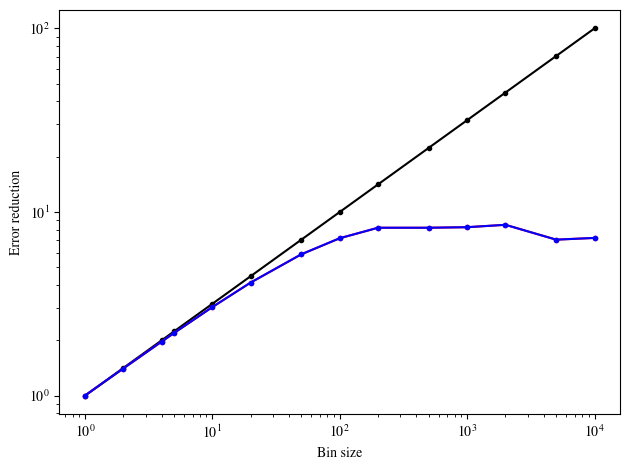

In [3]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=8
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [37]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.013228252530097961 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.44967476-0.029561331j), np.complex128(0.003630536560485138+0.028829396622215137j)) <f>: (np.float32(0.048250306), np.complex128(0.017647725886792667+0j))
Epoch 200: <Test loss>: 0.009261339902877808 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4502511-0.029561331j), np.complex128(0.0033440514546846426+0.028829396622215137j)) <f>: (np.float32(0.04767376), np.complex128(0.017562114226926533+0j))
Epoch 300: <Test loss>: 0.007953865453600883 <O>: (np.co

In [39]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.013876499608159065 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45099908-0.029561331j), np.complex128(0.004040943214442188+0.028829396622215137j)) <f>: (np.float32(0.046926077), np.complex128(0.016999011237136066+0j))
Epoch 400: <Test loss>: 0.00871005468070507 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4502684-0.029561331j), np.complex128(0.003106694660182511+0.028829396622215137j)) <f>: (np.float32(0.0476565), np.complex128(0.017506013400262393+0j))
Epoch 600: <Test loss>: 0.008208275772631168 <O>: (np.compl

In [41]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.013124710880219936 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45070872-0.029561331j), np.complex128(0.0036840055359834106+0.028829396622215137j)) <f>: (np.float32(0.047215994), np.complex128(0.017532278630445614+0j))
Epoch 800: <Test loss>: 0.009771750308573246 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4510162-0.029561331j), np.complex128(0.002818364746724924+0.028829396622215137j)) <f>: (np.float32(0.046908867), np.complex128(0.01792459876070086+0j))
Epoch 1200: <Test loss>: 0.009135379455983639 <O>: (np.c

In [43]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.013737574219703674 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45129505-0.029561331j), np.complex128(0.0035545893991015104+0.028829396622215137j)) <f>: (np.float32(0.04662987), np.complex128(0.017744767184306537+0j))
Epoch 1600: <Test loss>: 0.010142307728528976 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4519389-0.029561331j), np.complex128(0.0029735835798388823+0.028829396622215137j)) <f>: (np.float32(0.045986045), np.complex128(0.017833204284699332+0j))
Epoch 2400: <Test loss>: 0.008972269482910633 <O>: (np

In [4]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.016902264207601547 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4518254-0.029561331j), np.complex128(0.004716802492348226+0.028829396622215137j)) <f>: (np.float32(0.046099752), np.complex128(0.01853085061163776+0j))
Epoch 3200: <Test loss>: 0.014192755334079266 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4529522-0.029561331j), np.complex128(0.004339564064300774+0.028829396622215137j)) <f>: (np.float32(0.044972803), np.complex128(0.01926434268548775+0j))
Epoch 4800: <Test loss>: 0.012889306992292404 <O>: (np.co

### l3, w32

In [6]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.006694649811834097 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45295888-0.029561331j), np.complex128(0.0031375268739756395+0.028829396622215137j)) <f>: (np.float32(0.044965874), np.complex128(0.017823475594724976+0j))
Epoch 200: <Test loss>: 0.0047340006567537785 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.44997948-0.029561331j), np.complex128(0.002632389562490024+0.028829396622215137j)) <f>: (np.float32(0.0479456), np.complex128(0.017792535803095706+0j))
Epoch 300: <Test loss>: 0.0035344655625522137 <O>: (np.

In [8]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0071365851908922195 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45389554-0.029561331j), np.complex128(0.0031973873430359815+0.028829396622215137j)) <f>: (np.float32(0.044029627), np.complex128(0.017718075702319726+0j))
Epoch 400: <Test loss>: 0.004782842006534338 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45189765-0.029561331j), np.complex128(0.0027702574099846863+0.028829396622215137j)) <f>: (np.float32(0.04602733), np.complex128(0.017625282714448322+0j))
Epoch 600: <Test loss>: 0.004025221336632967 <O>: (np

In [10]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.006919678766280413 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45540446-0.029561331j), np.complex128(0.0031300289017734133+0.028829396622215137j)) <f>: (np.float32(0.04252043), np.complex128(0.01743490851011183+0j))
Epoch 800: <Test loss>: 0.004794979467988014 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45341605-0.029561331j), np.complex128(0.0027363896744188377+0.028829396622215137j)) <f>: (np.float32(0.04450922), np.complex128(0.017386959241748757+0j))
Epoch 1200: <Test loss>: 0.004324706271290779 <O>: (np.c

In [12]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.011449267156422138 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45670757-0.029561331j), np.complex128(0.003806064769712368+0.028829396622215137j)) <f>: (np.float32(0.04121788), np.complex128(0.017629626423303967+0j))
Epoch 1600: <Test loss>: 0.00804140418767929 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45469967-0.029561331j), np.complex128(0.0027681033160486786+0.028829396622215137j)) <f>: (np.float32(0.04322544), np.complex128(0.01792035857014037+0j))
Epoch 2400: <Test loss>: 0.007106090430170298 <O>: (np.co

In [14]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x1_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.5387142300605774 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.019318092614412308 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.4586479-0.029561331j), np.complex128(0.0036710964493673753+0.028829396622215137j)) <f>: (np.float32(0.03927703), np.complex128(0.018282646216176847+0j))
Epoch 3200: <Test loss>: 0.014093714766204357 <O>: (np.complex64(0.49792516-0.029561331j), np.complex128(0.018658675408452917+0.028829396622215137j)) <O-f>: (np.complex64(0.45659503-0.029561331j), np.complex128(0.0032118360105711794+0.028829396622215137j)) <f>: (np.float32(0.041329958), np.complex128(0.018466695655656232+0j))
Epoch 4800: <Test loss>: 0.013120058923959732 <O>: (n

# A=16
## acceptance rate 0.9

jack bin size 1: (np.complex64(0.18995525+0.008539376j), np.complex128(0.002160885557431305+0.0022291343268502385j))
bin size 1: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0021609048867536423+0.0022291329827617405j))
jack bin size 2: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0029726928805991044+0.0030720666184148294j))
bin size 2: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0029726890240663727+0.0030720660128363128j))
jack bin size 4: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004039570720018261+0.004185136594577255j))
bin size 4: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004039563396039394+0.0041851366443688585j))
jack bin size 5: (np.complex64(0.18995525+0.008539376j), np.complex128(0.0044448569646695765+0.004606235435592432j))
bin size 5: (np.complex64(0.18995525+0.008539376j), np.complex128(0.004444843166505231+0.004606234649255196j))
jack bin size 10: (np.complex64(0.18995525+0.008539376j), np.complex128(0.005813792

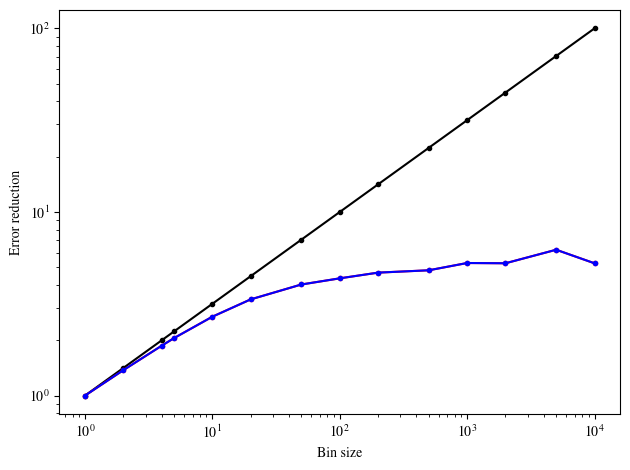

In [16]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.9.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=16
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [17]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [18]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.051169514656067 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.026944126933813095 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20536259-0.031027623j), np.complex128(0.003914003905004729+0.022707718422048596j)) <f>: (np.float32(0.028526327), np.complex128(0.024704754806596747+0j))
Epoch 200: <Test loss>: 0.023653892800211906 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20255776-0.031027623j), np.complex128(0.0032809004739333607+0.022707718422048596j)) <f>: (np.float32(0.031331312), np.complex128(0.025203782001454924+0j))
Epoch 300: <Test loss>: 0.022870758548378944 <O>: (np.c

In [19]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [20]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.051169514656067 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.02798972651362419 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20371267-0.031027623j), np.complex128(0.004197856144754112+0.022707718422048596j)) <f>: (np.float32(0.030176368), np.complex128(0.024712888096963374+0j))
Epoch 400: <Test loss>: 0.024584569036960602 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.2029631-0.031027623j), np.complex128(0.003758869307366243+0.022707718422048596j)) <f>: (np.float32(0.030925907), np.complex128(0.024901638484905227+0j))
Epoch 600: <Test loss>: 0.02406752109527588 <O>: (np.compl

In [21]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [22]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.051169514656067 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.02889261394739151 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20551942-0.031027623j), np.complex128(0.004254506785500622+0.022707718422048596j)) <f>: (np.float32(0.028369589), np.complex128(0.02500073391015831+0j))
Epoch 800: <Test loss>: 0.02625177800655365 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20421326-0.031027623j), np.complex128(0.004183001523120255+0.022707718422048596j)) <f>: (np.float32(0.0296758), np.complex128(0.025412003977738944+0j))
Epoch 1200: <Test loss>: 0.026864968240261078 <O>: (np.comple

In [23]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [24]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.051169514656067 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.03650437295436859 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20619632-0.031027623j), np.complex128(0.005398600371275018+0.022707718422048596j)) <f>: (np.float32(0.02769279), np.complex128(0.023701737628024286+0j))
Epoch 1600: <Test loss>: 0.03339454159140587 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20908082-0.031027623j), np.complex128(0.0052370301325662325+0.022707718422048596j)) <f>: (np.float32(0.024808204), np.complex128(0.024359596393753173+0j))
Epoch 2400: <Test loss>: 0.03353191167116165 <O>: (np.com

In [25]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [26]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.9_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.051169514656067 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.06688180565834045 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.20457815-0.031027623j), np.complex128(0.008733138291657594+0.022707718422048596j)) <f>: (np.float32(0.029310828), np.complex128(0.023048389012331496+0j))
Epoch 3200: <Test loss>: 0.066342793405056 <O>: (np.complex64(0.23388907-0.031027623j), np.complex128(0.025382198827815422+0.022707718422048596j)) <O-f>: (np.complex64(0.2047833-0.031027623j), np.complex128(0.007998777983479097+0.022707718422048596j)) <f>: (np.float32(0.029105654), np.complex128(0.022623854394577186+0j))
Epoch 4800: <Test loss>: 0.07067976891994476 <O>: (np.compl

## acceptance rate 0.95

jack bin size 1: (np.complex64(0.20760916+0.003631645j), np.complex128(0.0021468811565399583+0.002227062556743225j))
bin size 1: (np.complex64(0.20760916+0.003631645j), np.complex128(0.0021468921695325755+0.0022270626373902033j))
jack bin size 2: (np.complex64(0.20760916+0.003631645j), np.complex128(0.0030068911029195195+0.0031205487402423747j))
bin size 2: (np.complex64(0.20760916+0.003631645j), np.complex128(0.003006872230235995+0.003120544978785694j))
jack bin size 4: (np.complex64(0.20760916+0.003631645j), np.complex128(0.004190937521381372+0.004353812130588463j))
bin size 4: (np.complex64(0.20760916+0.003631645j), np.complex128(0.00419092744049164+0.004353810498440905j))
jack bin size 5: (np.complex64(0.20760916+0.003631645j), np.complex128(0.004654985031961827+0.004836370408026446j))
bin size 5: (np.complex64(0.20760916+0.003631645j), np.complex128(0.004654936550272279+0.004836372310881781j))
jack bin size 10: (np.complex64(0.20760916+0.003631645j), np.complex128(0.00638166633313

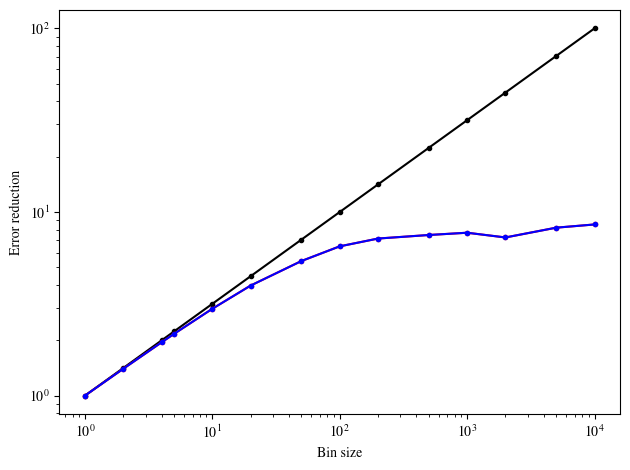

In [27]:
with open("u1_2d_obc/config/c_8x8_5.55_sweep1_0.95.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

model =  eval("gauge.U1_2D_OBC(geom=(8,8), beta=5.55)")

V=16
conf=conf[:,:V]

obs = jax.vmap(lambda x: model.observe(x, V))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [28]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [29]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.07851610332727432 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20334569-0.019788587j), np.complex128(0.00803719037517943+0.03214882239383252j)) <f>: (np.float32(0.044030834), np.complex128(0.022913985729347573+0j))
Epoch 200: <Test loss>: 0.040254272520542145 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20420036-0.019788587j), np.complex128(0.005319649403282628+0.03214882239383252j)) <f>: (np.float32(0.043176338), np.complex128(0.023729470382274152+0j))
Epoch 300: <Test loss>: 0.032062631100416183 <O>: (np.complex64

In [30]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [31]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.07818962633609772 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20558685-0.019788587j), np.complex128(0.008405981913319042+0.03214882239383252j)) <f>: (np.float32(0.04178999), np.complex128(0.023520119853595863+0j))
Epoch 400: <Test loss>: 0.041395653039216995 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20476791-0.019788587j), np.complex128(0.005789667625693279+0.03214882239383252j)) <f>: (np.float32(0.042608757), np.complex128(0.023831549570152377+0j))
Epoch 600: <Test loss>: 0.03391341492533684 <O>: (np.complex64(

In [32]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [33]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.0824524387717247 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20204659-0.019788587j), np.complex128(0.008912649164313977+0.03214882239383252j)) <f>: (np.float32(0.045330256), np.complex128(0.023964010362774218+0j))
Epoch 800: <Test loss>: 0.04599392041563988 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20856114-0.019788587j), np.complex128(0.005983172243573052+0.03214882239383252j)) <f>: (np.float32(0.038815454), np.complex128(0.024347639015777182+0j))
Epoch 1200: <Test loss>: 0.03673466667532921 <O>: (np.complex64(

In [34]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [35]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.09190759807825089 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.21132989-0.019788587j), np.complex128(0.009545897977696928+0.03214882239383252j)) <f>: (np.float32(0.036046814), np.complex128(0.021187308685194636+0j))
Epoch 1600: <Test loss>: 0.046890780329704285 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.21421285-0.019788587j), np.complex128(0.006910270423827479+0.03214882239383252j)) <f>: (np.float32(0.033163793), np.complex128(0.02223660666078468+0j))
Epoch 2400: <Test loss>: 0.038072407245635986 <O>: (np.complex

In [36]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [16]*2, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [37]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l2_w16_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.2813709080219269 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.22024877-0.019788587j), np.complex128(0.018499060346171797+0.03214882239383252j)) <f>: (np.float32(0.027127877), np.complex128(0.026353330341708735+0j))
Epoch 3200: <Test loss>: 0.17474091053009033 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.22605976-0.019788587j), np.complex128(0.014716336414804436+0.03214882239383252j)) <f>: (np.float32(0.021317095), np.complex128(0.02645762400919514+0j))
Epoch 4800: <Test loss>: 0.16068103909492493 <O>: (np.complex64

### l3, w32

In [38]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.04600840061903 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.2045701-0.019788587j), np.complex128(0.005084884625700432+0.03214882239383252j)) <f>: (np.float32(0.042806573), np.complex128(0.023490071131213146+0j))
Epoch 200: <Test loss>: 0.03492321819067001 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.2043803-0.019788587j), np.complex128(0.004792454068403769+0.03214882239383252j)) <f>: (np.float32(0.042996228), np.complex128(0.02411980539698696+0j))
Epoch 300: <Test loss>: 0.030338382348418236 <O>: (np.complex64(0.247

In [40]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.04929261654615402 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.2065306-0.019788587j), np.complex128(0.005473276642608532+0.03214882239383252j)) <f>: (np.float32(0.040846128), np.complex128(0.022883388968931665+0j))
Epoch 400: <Test loss>: 0.035847753286361694 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20547974-0.019788587j), np.complex128(0.004860413829174974+0.03214882239383252j)) <f>: (np.float32(0.04189712), np.complex128(0.02354679712718922+0j))
Epoch 600: <Test loss>: 0.03167201206088066 <O>: (np.complex64(0.

In [42]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.05942153558135033 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20530596-0.019788587j), np.complex128(0.005649533793164166+0.03214882239383252j)) <f>: (np.float32(0.042070776), np.complex128(0.022943360567926514+0j))
Epoch 800: <Test loss>: 0.0454460084438324 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20564444-0.019788587j), np.complex128(0.0055989696729631085+0.03214882239383252j)) <f>: (np.float32(0.04173224), np.complex128(0.024262747924436168+0j))
Epoch 1200: <Test loss>: 0.04073203355073929 <O>: (np.complex64(

In [44]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.1259441375732422 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.21117115-0.019788587j), np.complex128(0.00772858914380532+0.03214882239383252j)) <f>: (np.float32(0.03620556), np.complex128(0.022835360539519355+0j))
Epoch 1600: <Test loss>: 0.10670885443687439 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20934342-0.019788587j), np.complex128(0.007539750460847007+0.03214882239383252j)) <f>: (np.float32(0.03803311), np.complex128(0.023805095571313283+0j))
Epoch 2400: <Test loss>: 0.10004955530166626 <O>: (np.complex64(0.

In [46]:
key = jax.random.PRNGKey(0)
g1 = CV_MLP_Periodic(V, [32]*3, 1)
g_params = g1.init(key, jnp.zeros(V))
model.shape=model.shape[:2]

g1_grad = jax.jit(
    jax.grad(lambda y, p: g1.apply(p, y)[0][0], argnums=0))
dS = jax.jit(jax.grad(lambda y: model.action(y).real))
j1 = jax.jit(jax.jacfwd(lambda x, p: g1.apply(p, x)[0], argnums=0))

# define subtraction function
@jax.jit
def f(x, p):
    j=j1(x,p)
    return jnp.trace(j) - g1.apply(p,x)[0]@dS(x)
    

@jax.jit
def Loss(x, p):
    _,y = g1.apply(p,x)
    al = 0
   
    return jnp.real(model.observe(x, V) - f(x, p) - y[0])**2 + al * l2_regularization(p)

def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, V))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

def save():
    with open("correlated/u1_2d_obc/cv_8x2_5.55_new_l3_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_acc0.95_bs"+str(binsize)+"_40min.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1].real/jackknife(obs-fs)[1].real])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 1.0069154500961304 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.4095263183116913 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20201607-0.019788587j), np.complex128(0.017285133775182197+0.03214882239383252j)) <f>: (np.float32(0.04536047), np.complex128(0.024436719553416354+0j))
Epoch 3200: <Test loss>: 0.38154029846191406 <O>: (np.complex64(0.24737677-0.019788587j), np.complex128(0.023909582066996553+0.03214882239383252j)) <O-f>: (np.complex64(0.20193207-0.019788587j), np.complex128(0.01675067389170784+0.03214882239383252j)) <f>: (np.float32(0.045444533), np.complex128(0.023810478522661497+0j))
Epoch 4800: <Test loss>: 0.35577988624572754 <O>: (np.complex64(

# 16x16

jack bin size 1: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0021497874155711754+0.002233046056596264j))
bin size 1: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0021498116505467547+0.0022330456037761588j))
jack bin size 2: (np.complex64(0.19796479+0.001086031j), np.complex128(0.00240338643459402+0.0025472272163158346j))
bin size 2: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0024033725860828836+0.0025472271675026715j))
jack bin size 4: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0026182763542060413+0.0028452691797064616j))
bin size 4: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0026182746706217334+0.0028452690909835324j))
jack bin size 5: (np.complex64(0.19796479+0.001086031j), np.complex128(0.002669472817490841+0.002925370641752643j))
bin size 5: (np.complex64(0.19796479+0.001086031j), np.complex128(0.0026694586718969955+0.002925370829429657j))
jack bin size 10: (np.complex64(0.19796479+0.001086031j), np.complex128(0.00276607

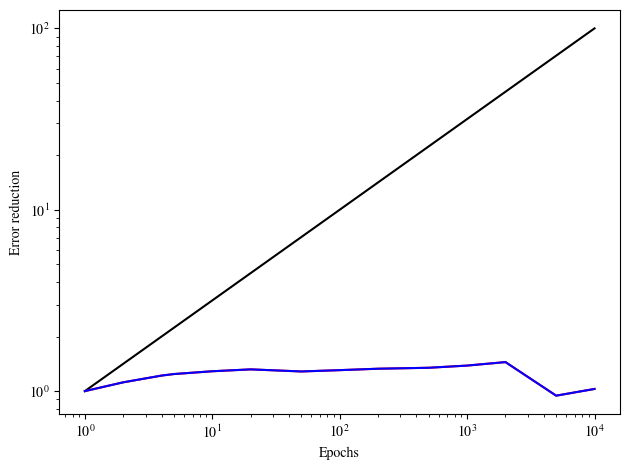

In [ ]:
with open("u1_2d_obc/config/c_16x16_5.55_sweep1.pickle", "rb") as aa:
    conf = pickle.load(aa)

model =  eval("gauge.U1_2D_OBC(geom=(16,16), beta=5.55)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 16))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()